In [276]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from a2c_ppo_acktr.arguments import get_args
from rewarder import History
import pickle
import seaborn
from collections import defaultdict
import os
import math

from matplotlib.animation import FuncAnimation

from pyhtmlwriter.Element import Element
from pyhtmlwriter.TableRow import TableRow
from pyhtmlwriter.Table import Table
from pyhtmlwriter.TableWriter import TableWriter

In [277]:
class Args:
    def __init__(self):
        pass
    

In [372]:
def make_gif(iteration, skip_if_exists=True):
    i = iteration
    
    gif_name = os.path.join(gif_dir, 'iteration{}.gif'.format(i))
    if skip_if_exists and os.path.isfile(gif_name):
        print('{} exists; skipping.'.format(gif_name))
        return gif_name

    iteration = history.all[i]
    generative_model = iteration['generative_model']
    standardizer = iteration['standardizer']
    episodes = iteration['episodes']
    means = generative_model.means_
    if history.args.standardize_embeddings:
        means = standardizer.inverse_transform(means)

    def sort_episodes_by_task(episodes):
        tasks = defaultdict(list)
        for episode in episodes:
            task_id = episode[1]
            tasks[task_id].append(episode[0])
        for key, value in tasks.items():
            tasks[key] = torch.stack(value, dim=0)

        return tasks
    tasks = sort_episodes_by_task(episodes)
    num_clusters = len(tasks.keys())
    if history.args.max_components:
        max_components = history.args.max_components
    else:
        max_components = 50

    fig, axes = plt.subplots(nrows=math.ceil(max_components//10), ncols=10, sharex=True, sharey=True,
                            figsize=[50, 5*math.ceil(max_components//10)])
    scats = []
    axes = axes.reshape([-1])

    for j in range(num_clusters):
        ax = axes[j]
        limit = 10 + 1
        ax.set_xlim(left=-limit, right=limit)
        ax.set_ylim(bottom=-limit, top=limit)
        ax.scatter(means[j, 0], means[j, 1], 
                   edgecolors='g', s=30**2, facecolors='none', linewidths=6)
        scats.append(ax.scatter(None, None))
        ax.set_title('(x, y, speed): {}'.format(np.round(means[j], decimals=3)))
    trajectories = [tasks[j].numpy() for j in range(num_clusters)]  # (trajectory, time, state)
    def update(t):
        for j in range(num_clusters):
            ax = axes[j]
            scat = scats[j]
            label = 'timestep {0}'.format(t)
            # Update the line and the axes (with a new xlabel). Return a tuple of
            # "artists" that have to be redrawn for this frame.
            data = trajectories[j][:, t:t+1, :2].reshape([-1, 2])
            scat.set_offsets(data)
            # scat.set_offsets(trajectories[0, :t, :2])
            ax.set_xlabel(label)
        return scats, axes

    anim = FuncAnimation(fig, update, frames=T, interval=100)
    anim.save(gif_name, writer='imagemagick', fps=10)
    return gif_name

In [280]:
def make_html(gif_names):
    table = Table()
    
    for i, gif_name in enumerate(gif_names):
        row = TableRow(rno=i)
        
        e = Element()
        e.addTxt('iteration {}'.format(i))
        row.addElement(e)
        
        e = Element()
        e.addImg(gif_name, width=1000)
        row.addElement(e)
        
        table.addRow(row)
        
    tw = TableWriter(table, args.log_dir, rowsPerPage=min(num_iterations, 100))
    tw.write()

<IPython.core.display.Javascript object>


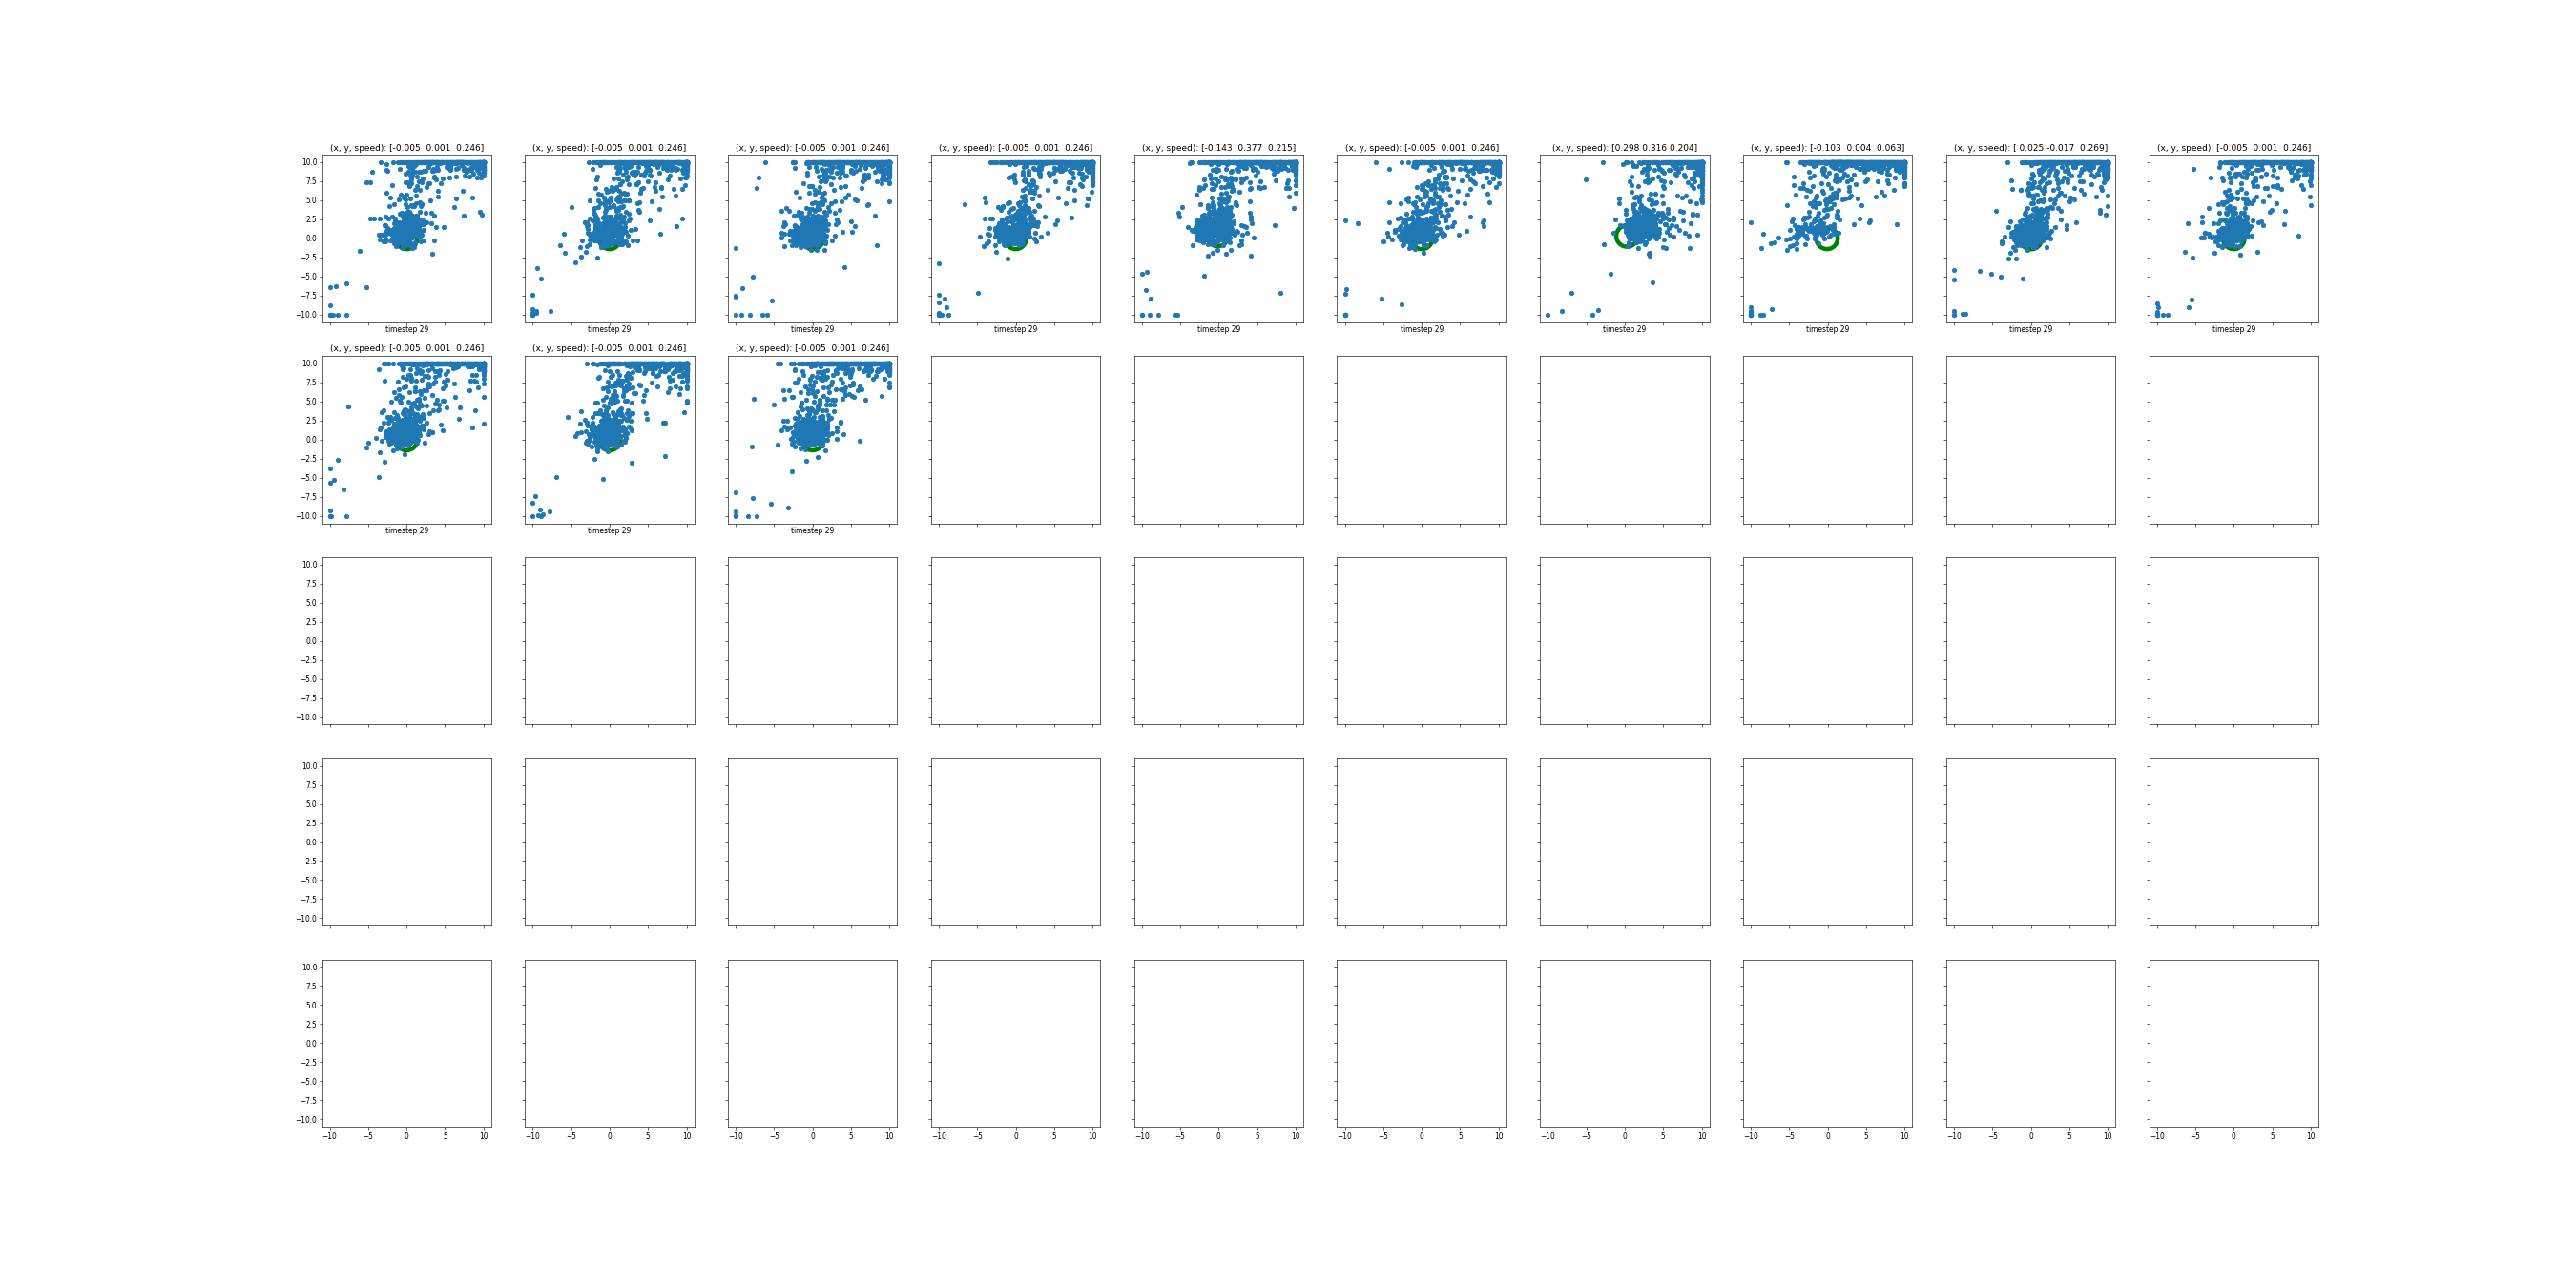

<IPython.core.display.Javascript object>


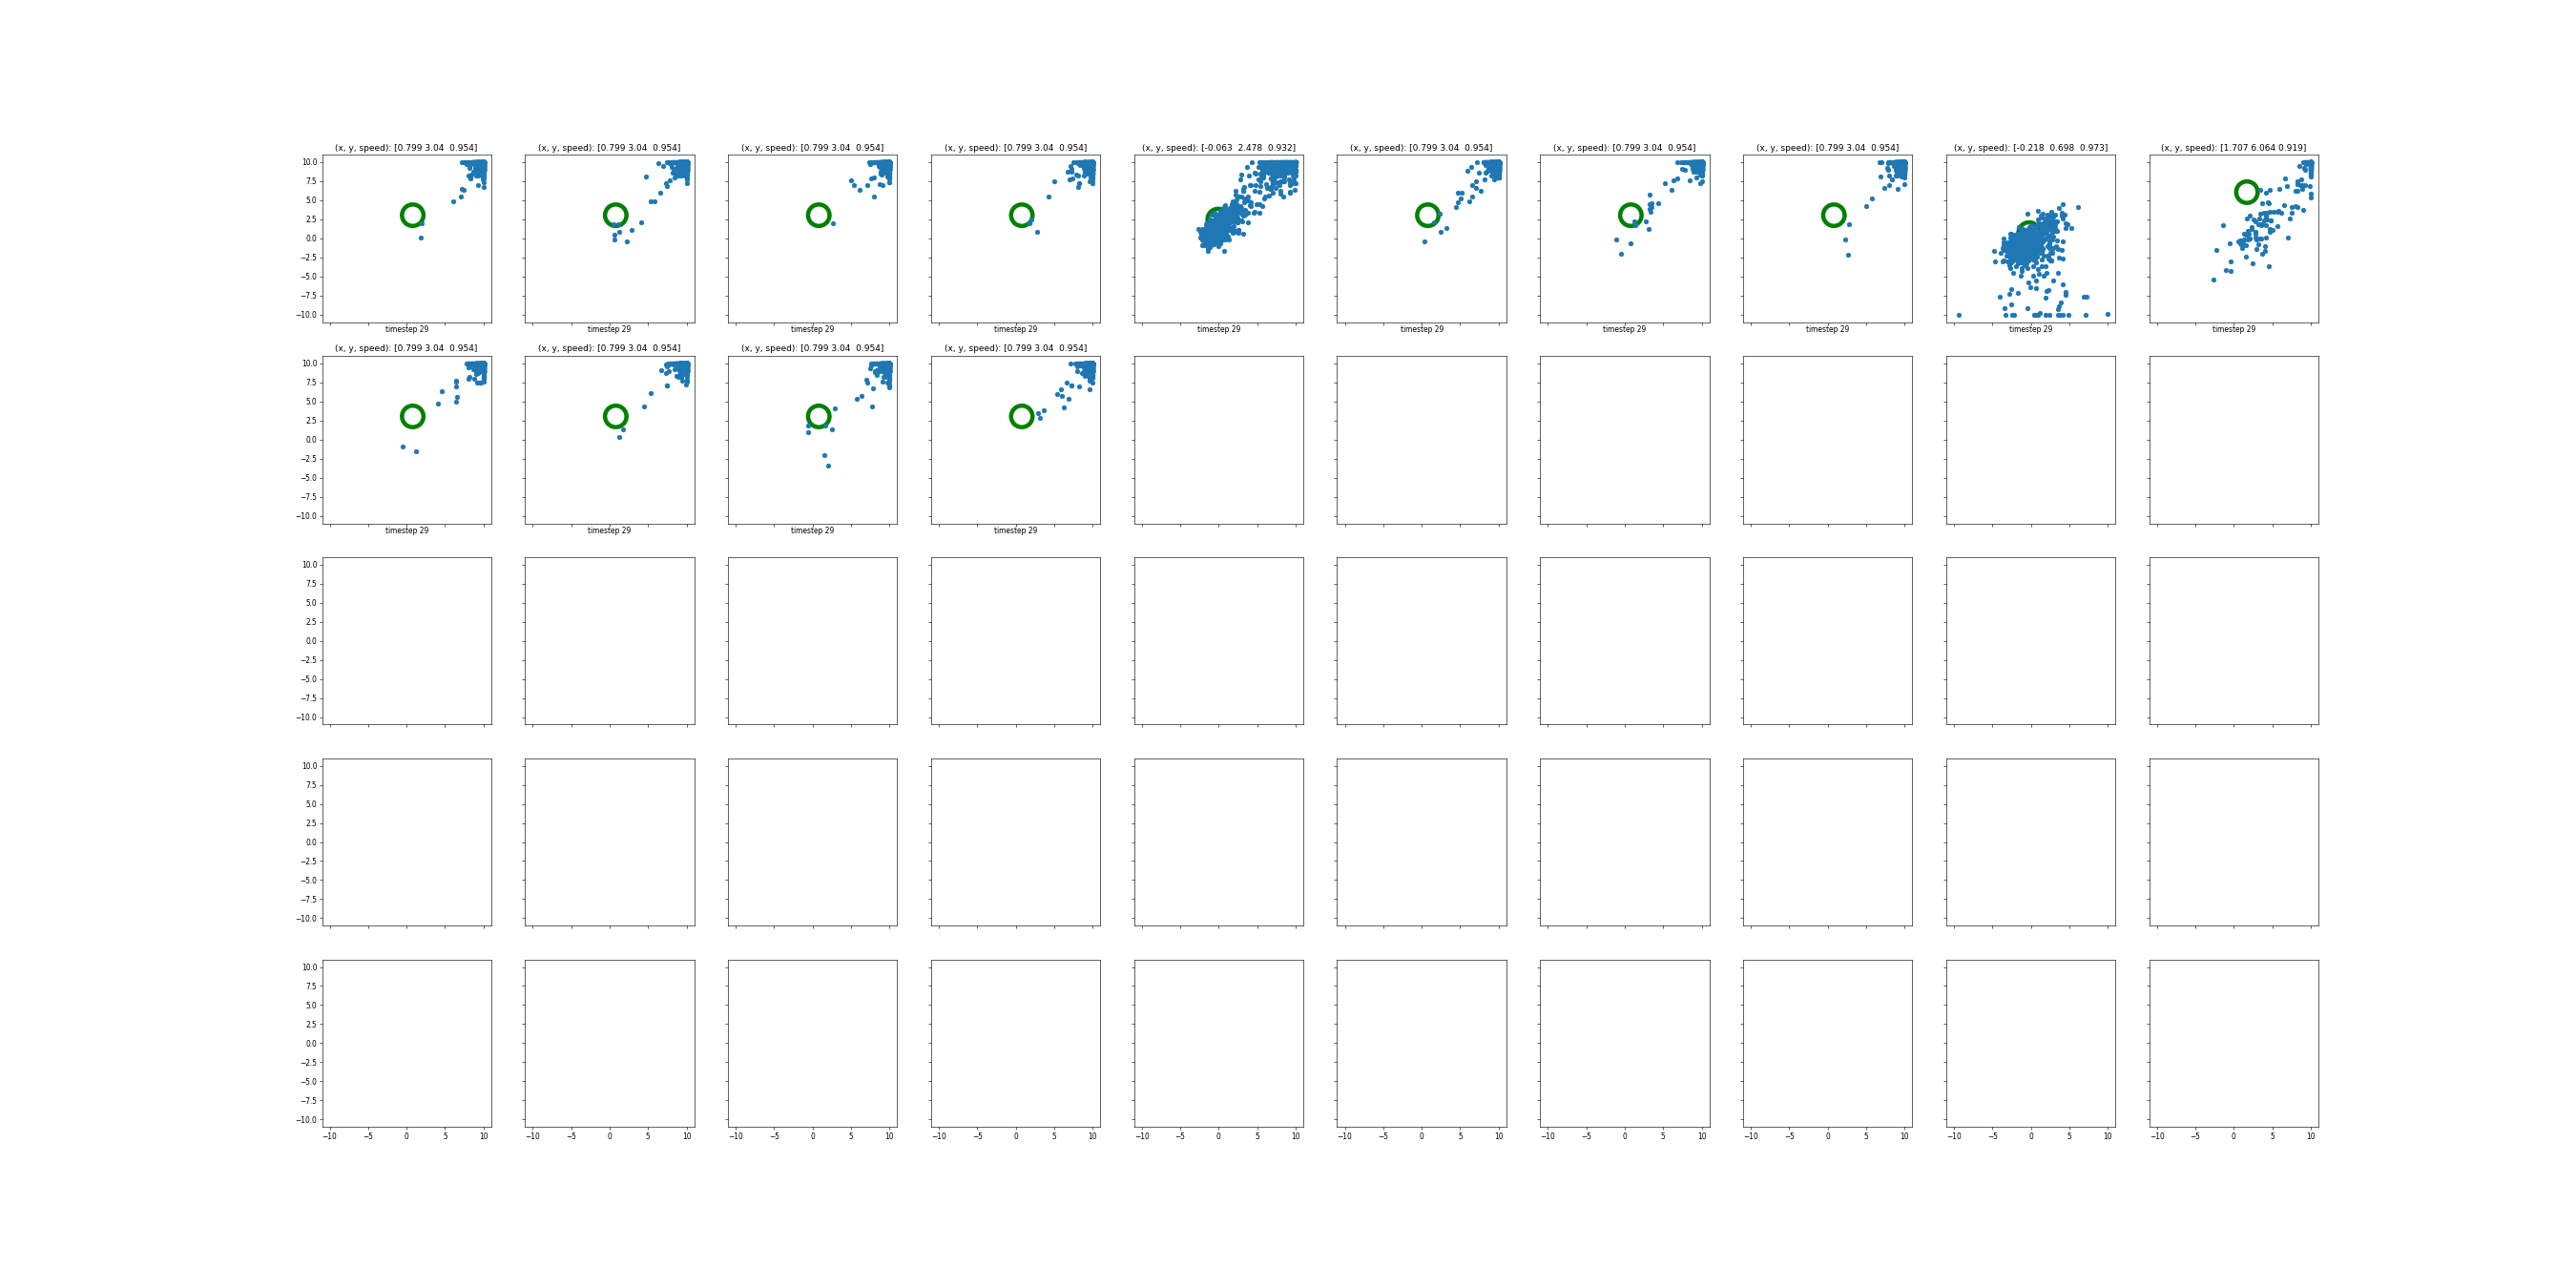

<IPython.core.display.Javascript object>


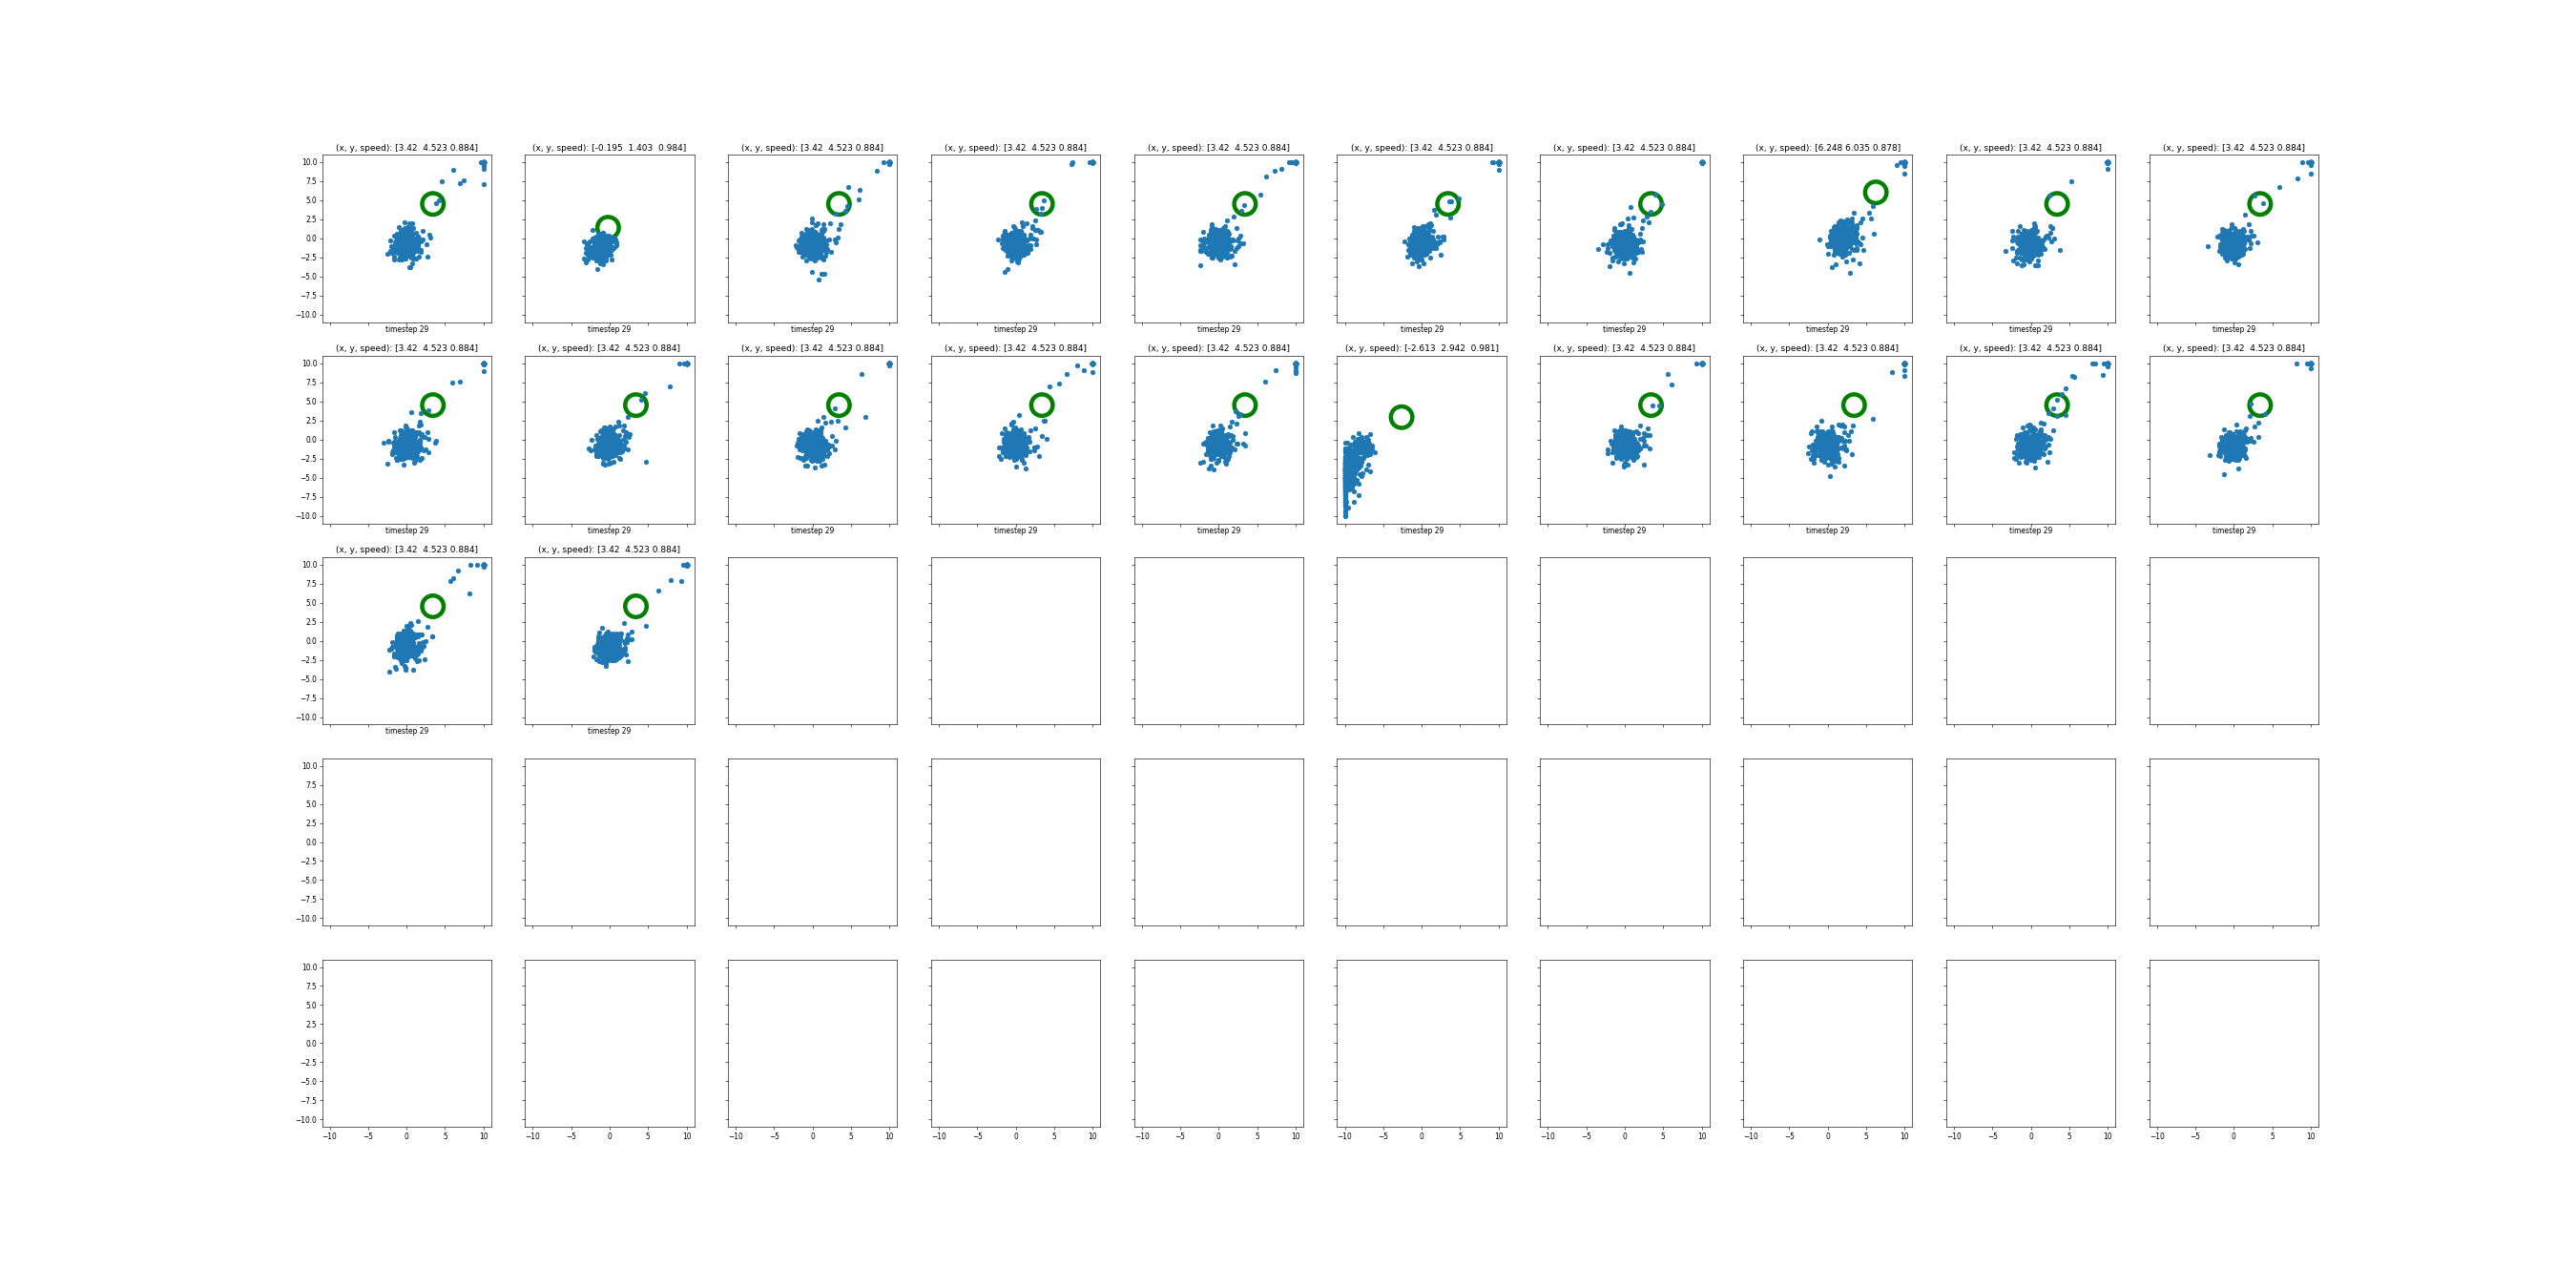

<IPython.core.display.Javascript object>


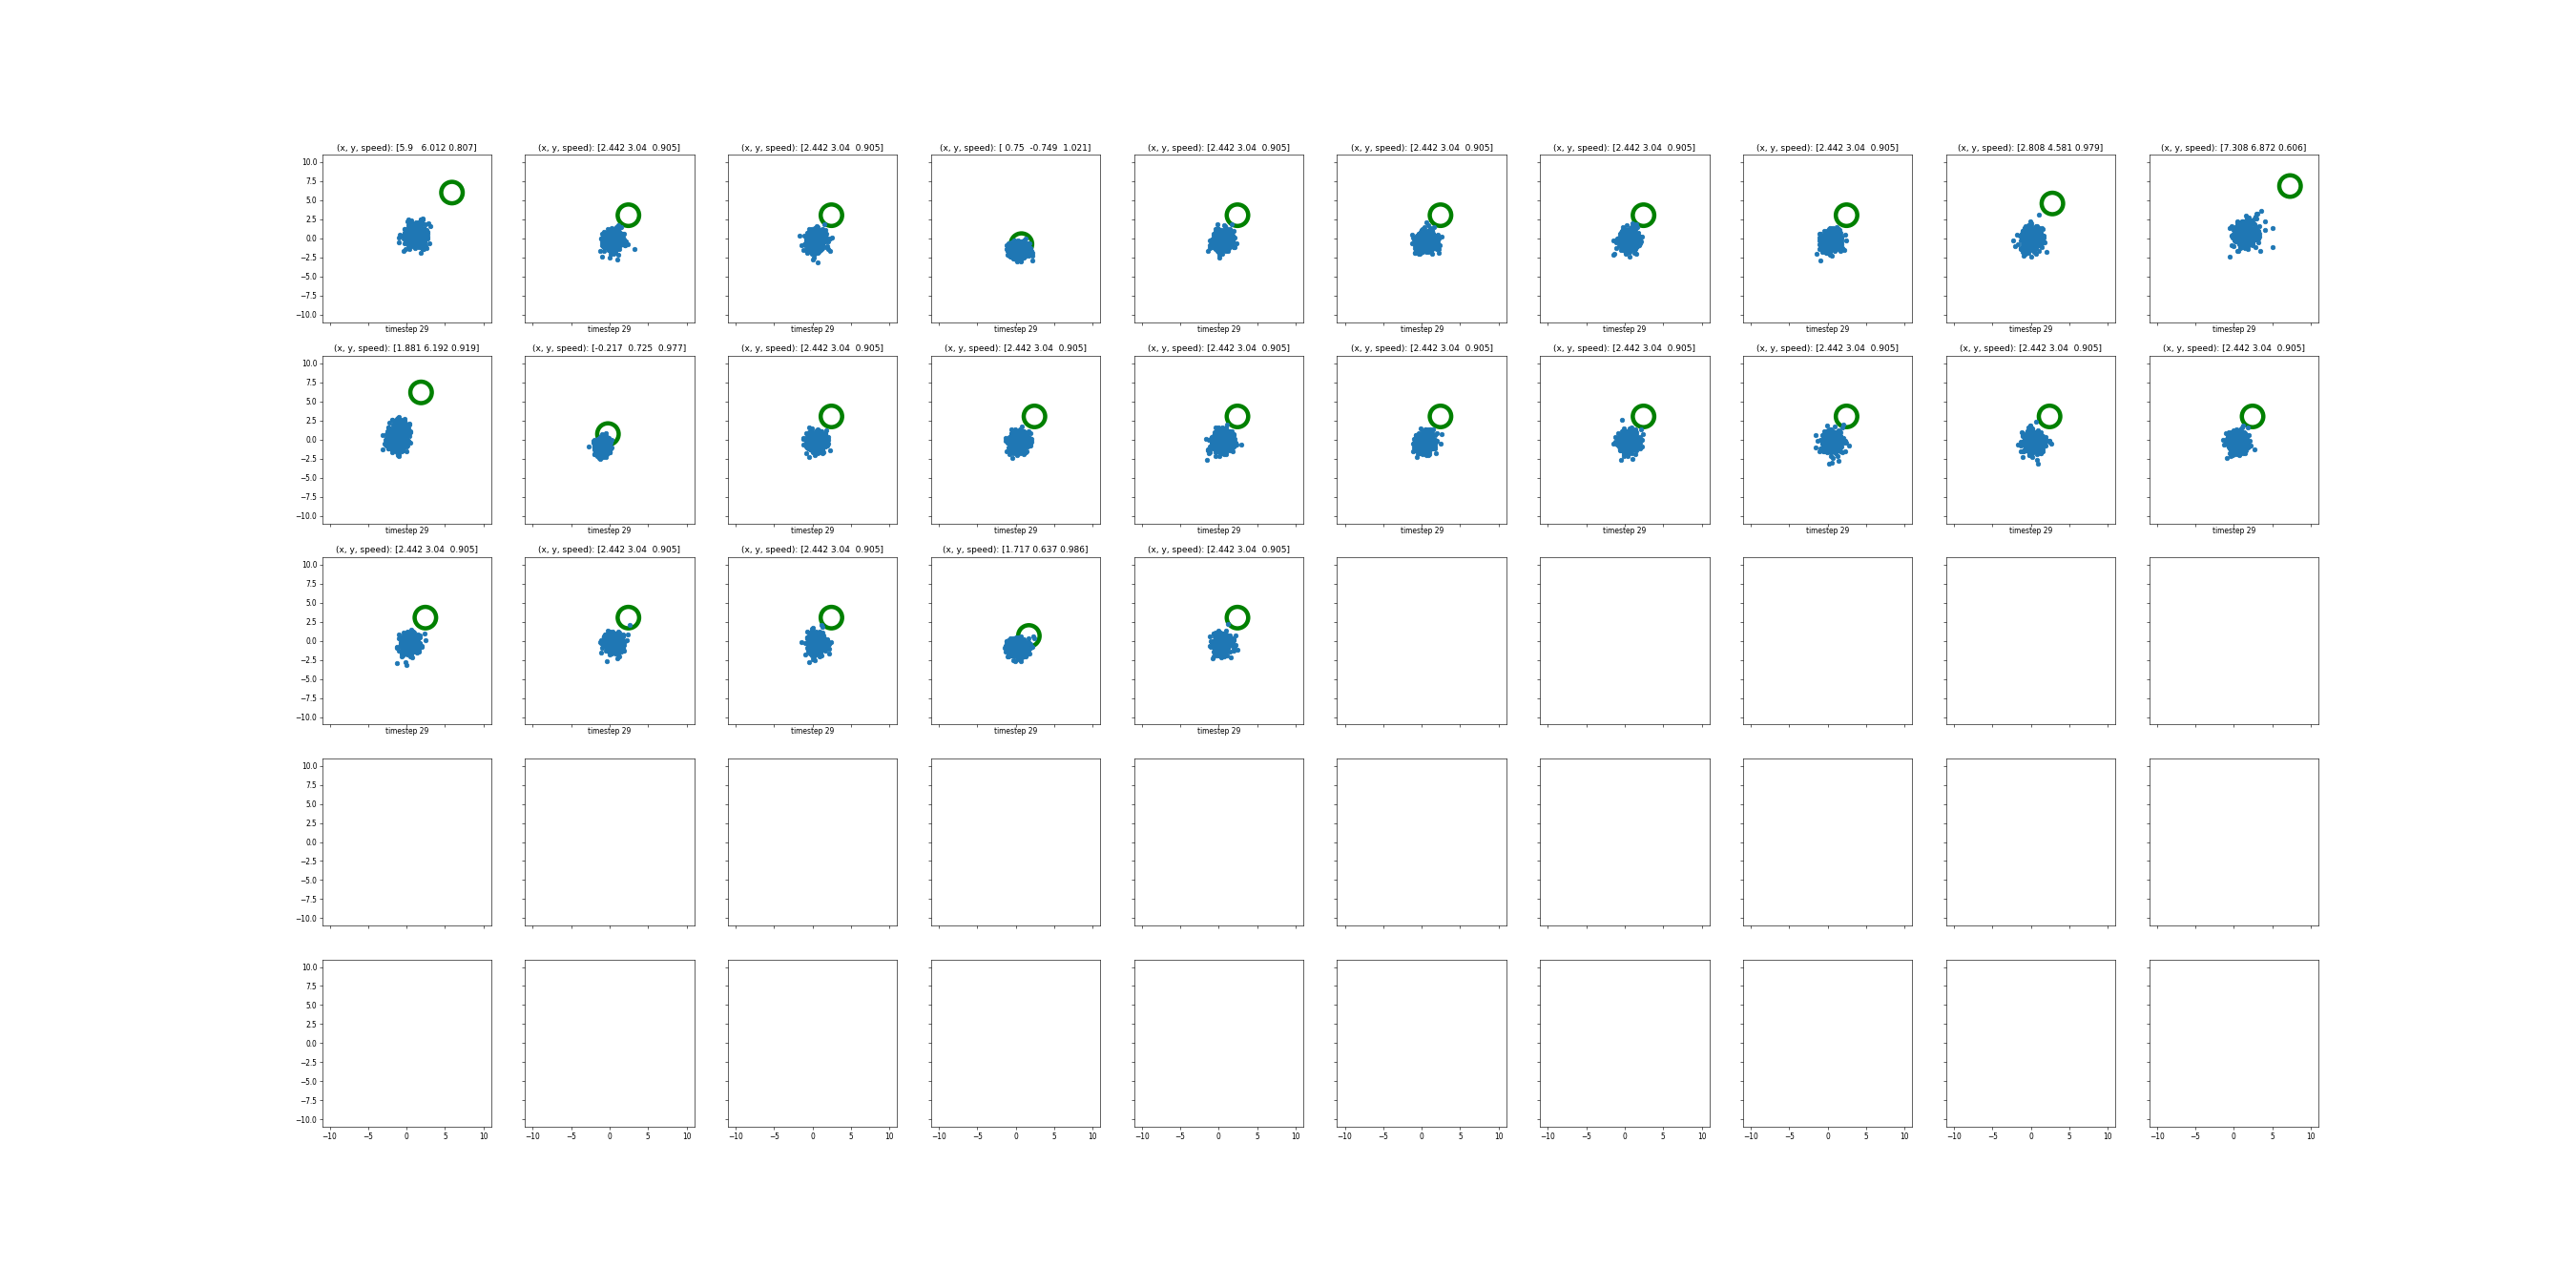

<IPython.core.display.Javascript object>


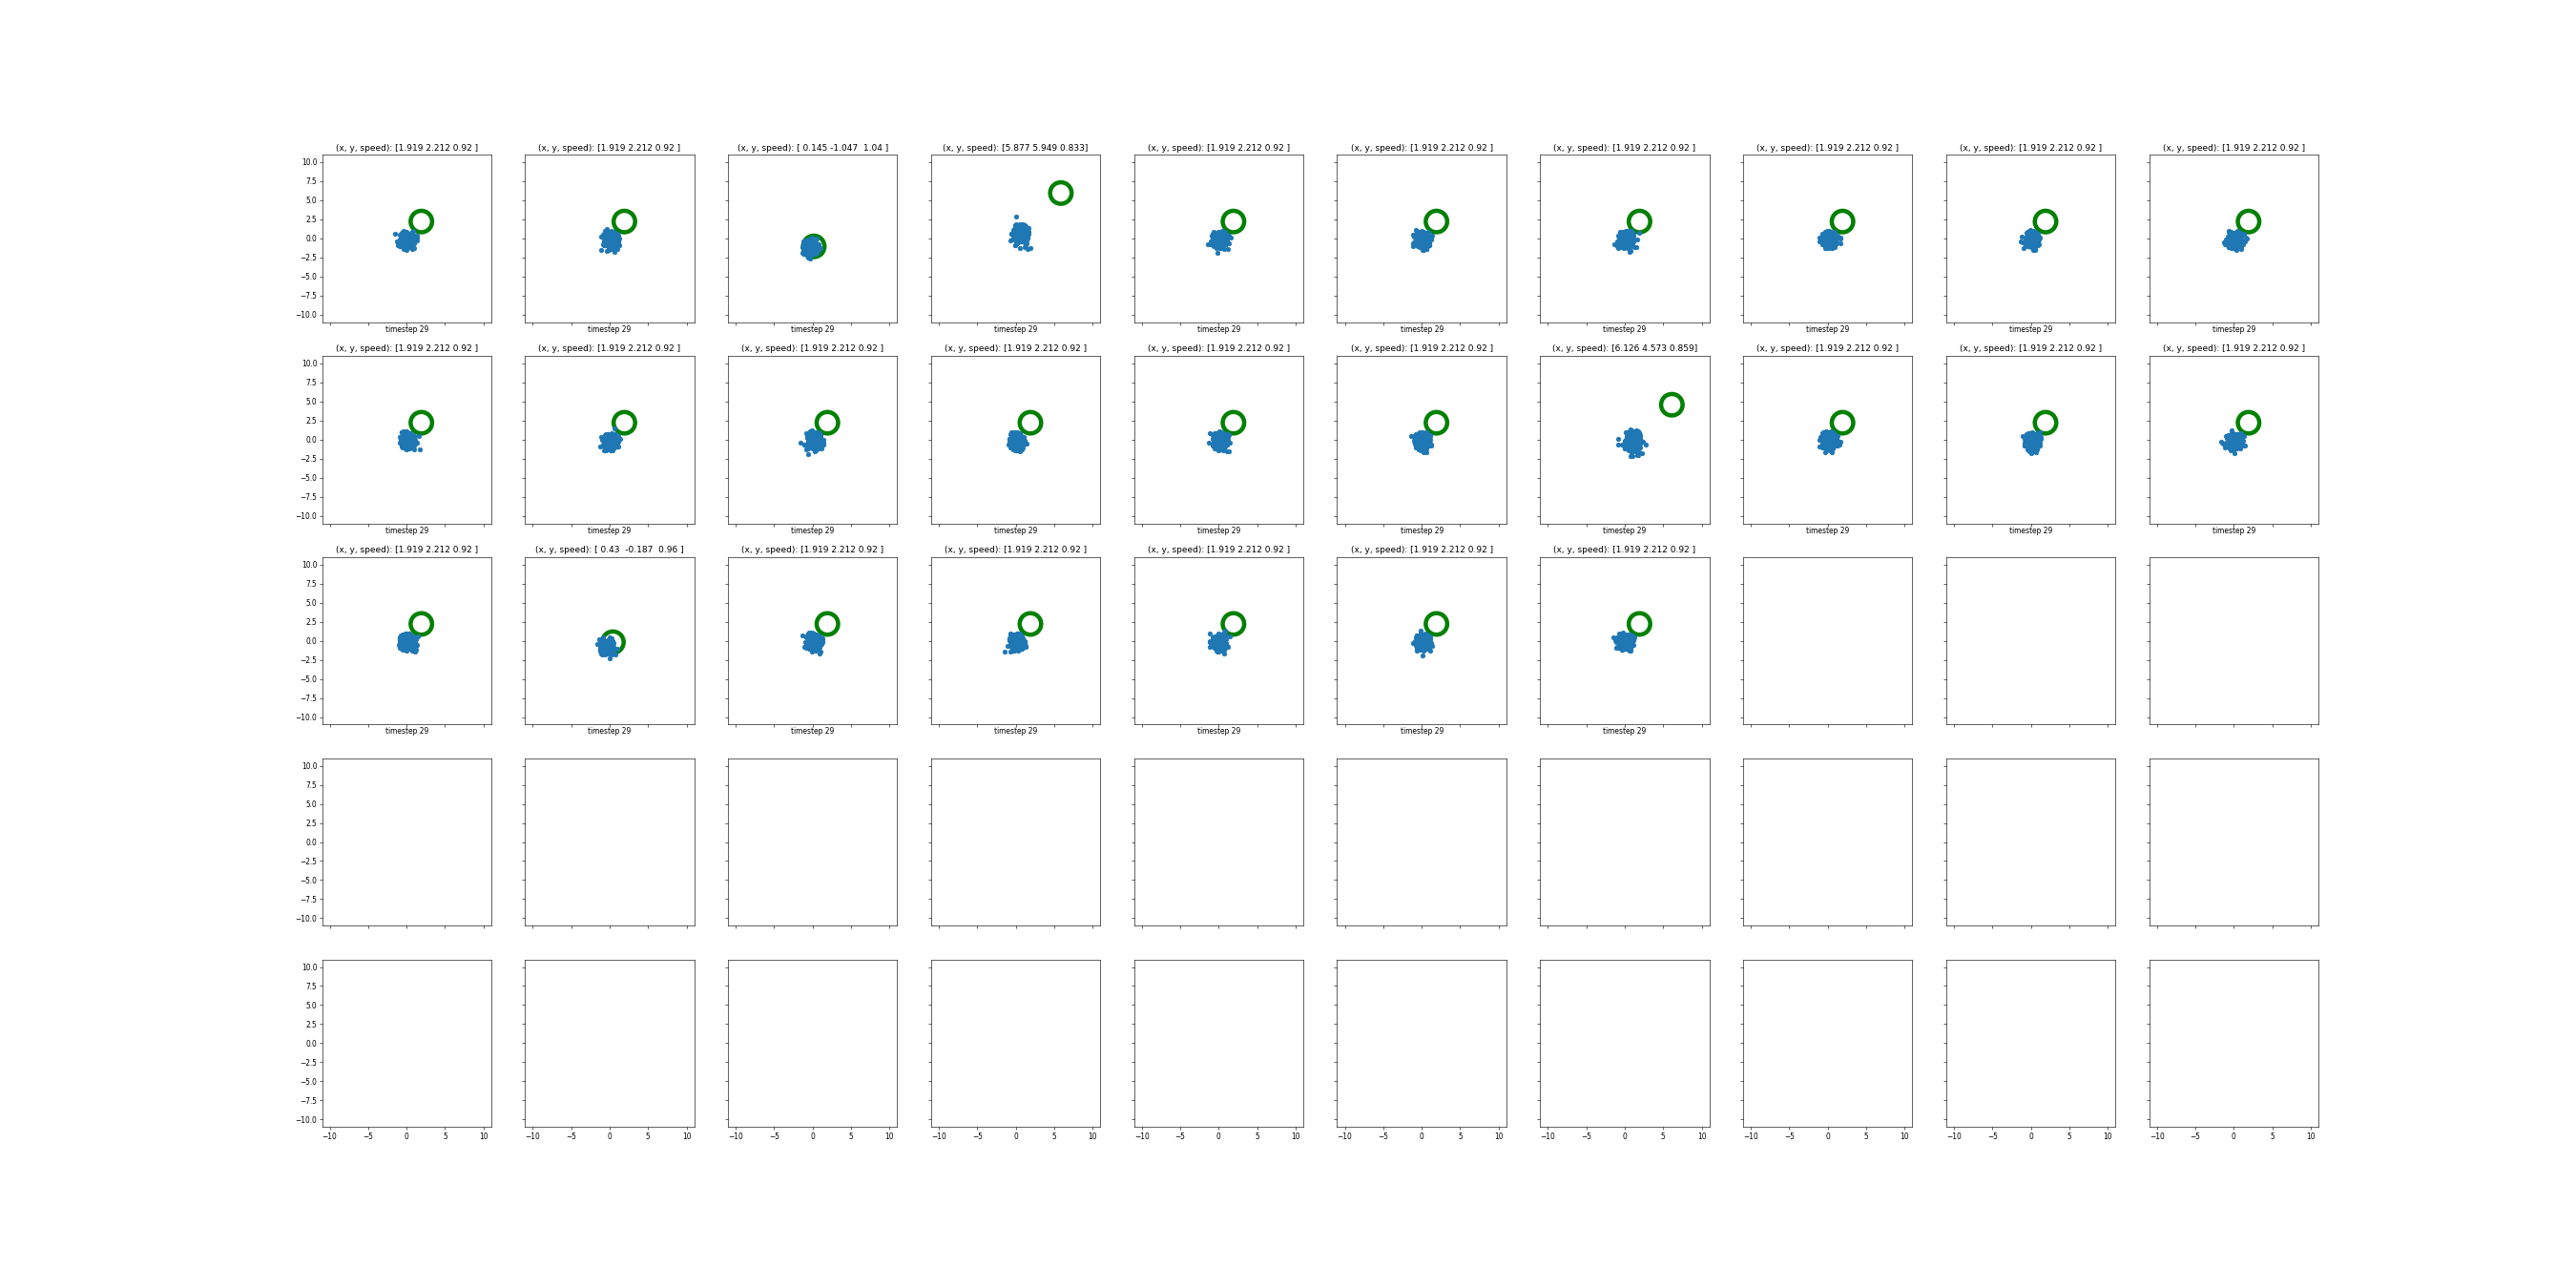

In [374]:
args = Args()
args.log_dir = '/home/kylehsu/experiments/umrl/output/point2d/20181219/clustering_z|w_big'
gif_dir = os.path.join(args.log_dir, 'vis')
os.makedirs(gif_dir, exist_ok=True)
history_shell = History(args)
history = pickle.load(open(history_shell.filename, 'rb'))

gif_names = []
num_iterations = len(history.all)
for i in range(num_iterations):
    gif_names.append(make_gif(i, True))

In [375]:
history.args

Namespace(add_timestep=False, algo='ppo', alpha=0.99, clip_param=0.2, clustering_period=100, component_constraint_l_2=0.1, component_constraint_l_inf=0.1, component_weight_threshold=1e-05, context='cluster_mean', cuda=False, cuda_deterministic=False, entropy_coef=0, env_name='Point2DEnv-v0', episode_length=30, eps=1e-05, eval_interval=None, fit_on_entire_history=True, fixed_start=True, gamma=1, log_dir='./output/point2d/20181219/clustering_z|w_big', log_interval=10, lr=0.0007, max_components=200, max_grad_norm=0.5, no_cuda=False, num_env_steps=10000000.0, num_mini_batch=32, num_processes=10, num_steps=300, num_updates=5000, obs='pos_speed', port=8097, ppo_epoch=4, recurrent_policy=False, reward='z|w', save_dir='./trained_models/', save_interval=100, seed=1, skew=False, sparse_reward=False, standardize_embeddings=True, tau=0.95, trajectory_embedding='avg', uniform_cluster_categorical=True, use_gae=True, use_linear_clip_decay=False, use_linear_lr_decay=False, value_loss_coef=0.5, vis=Fal

In [296]:
iteration = history.all[1]
dpgmm = iteration['generative_model']

In [303]:
dpgmm.means_[30:35]

array([[-0.01808389,  0.17056146,  0.90420675],
       [-0.01808575,  0.1705605 ,  0.90420686],
       [-0.0180876 ,  0.17055955,  0.90420697],
       [-0.01808945,  0.17055861,  0.90420709],
       [-0.01809128,  0.17055766,  0.9042072 ]])

In [304]:
dpgmm.covariances_[30:35]

array([[[4.59201464e-01, 3.97765273e-01, 5.03447757e-04],
        [3.97765273e-01, 6.60780730e-01, 1.38264367e-03],
        [5.03447757e-04, 1.38264367e-03, 2.07430081e-03]],

       [[4.59201364e-01, 3.97764984e-01, 5.03472689e-04],
        [3.97764984e-01, 6.60780356e-01, 1.38267670e-03],
        [5.03472689e-04, 1.38267670e-03, 2.07429992e-03]],

       [[4.59201264e-01, 3.97764695e-01, 5.03497527e-04],
        [3.97764695e-01, 6.60779982e-01, 1.38270960e-03],
        [5.03497527e-04, 1.38270960e-03, 2.07429904e-03]],

       [[4.59201165e-01, 3.97764408e-01, 5.03522270e-04],
        [3.97764408e-01, 6.60779610e-01, 1.38274238e-03],
        [5.03522270e-04, 1.38274238e-03, 2.07429816e-03]],

       [[4.59201066e-01, 3.97764122e-01, 5.03546919e-04],
        [3.97764122e-01, 6.60779239e-01, 1.38277503e-03],
        [5.03546919e-04, 1.38277503e-03, 2.07429728e-03]]])

In [305]:
dpgmm.weights_[30:35]

array([1.00404236e-04, 1.00078646e-04, 9.97541162e-05, 9.94306447e-05,
       9.91082278e-05])

In [306]:
1/50

0.02

In [309]:
2e-2/200

0.0001

In [310]:
dpgmm.weights_

array([2.31429527e-04, 3.39721382e-01, 5.74573953e-03, 1.33023545e-02,
       1.03168082e-04, 4.49256760e-02, 1.03133565e-04, 1.03115686e-04,
       2.73583734e-01, 1.03064771e-04, 1.03031742e-04, 1.46735902e-02,
       7.39625060e-02, 1.02918657e-04, 1.02873182e-04, 1.02827728e-04,
       1.02782294e-04, 2.57892843e-02, 1.02685859e-04, 1.02634864e-04,
       1.02583895e-04, 1.02532951e-04, 1.02482033e-04, 1.02431140e-04,
       1.75000304e-01, 1.02048238e-04, 1.01717286e-04, 1.01387414e-04,
       1.01058617e-04, 1.00730892e-04, 1.00404236e-04, 1.00078646e-04,
       9.97541162e-05, 9.94306447e-05, 9.91082278e-05, 9.87868618e-05,
       9.84665433e-05, 9.81472688e-05, 3.02186983e-02, 1.87909700e-06,
       3.68450391e-08, 7.22451748e-10, 1.41657205e-11, 2.77759226e-13,
       5.44625934e-15, 1.06789399e-16, 2.09390978e-18, 4.10570545e-20,
       8.05040285e-22, 1.57851036e-23])

In [325]:
x = np.argwhere(dpgmm.weights_ >= 5e-4).reshape([-1])

In [326]:
dpgmm.means_[x]

array([[ 6.70182934e-02, -1.15128234e-01,  8.86167199e-01],
       [-1.79249093e+00, -1.59348204e+00,  9.20808987e-01],
       [-3.96291399e+00, -4.90324231e+00,  9.12688097e-01],
       [-1.64432236e-01,  1.67502555e-01,  9.41588691e-01],
       [-5.14079386e-03,  4.66807497e-02,  9.54681258e-01],
       [-3.42136194e+00, -1.25028730e+00,  9.48331282e-01],
       [-5.34321848e-01,  4.30973756e-01,  8.50313673e-01],
       [ 6.48187017e-01,  1.78111468e+00,  9.78388597e-01],
       [-1.09128585e-01,  1.72406008e-02,  8.56109642e-01],
       [ 3.85866442e+00,  6.28062123e+00,  9.15907604e-01]])

In [333]:
np.random.choice(x, size=1, replace=False)

array([17])

In [331]:
x

array([ 1,  2,  3,  5,  8, 11, 12, 17, 24, 38])

In [339]:
weights = np.array([0.1, 0.2])
weights = weights / sum(weights)
y = np.random.choice([0, 1], size=100, replace=True, p=weights)
sum(y) / 100

0.72